In [ ]:
import astropy
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm
from astropy import units as u
import galpy
from galpy.orbit import Orbit
from astropy.coordinates import SkyCoord
from galpy.potential import MWPotential2014
from astropy.coordinates import SkyCoord, Galactocentric, CartesianDifferential
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse, Circle
import astropy.units as u
from astropy.coordinates import ICRS
import astropy.coordinates as apycoords
from astropy.coordinates import CylindricalRepresentation, CylindricalDifferential


# Error propegation for velocity components

In [2]:
vphi_data = 'v_dataset.fits'

with fits.open(vphi_data) as hdul:
    data = hdul[1].data  
    
    df_v = pd.DataFrame({col.name: data[col.name].byteswap().newbyteorder() if data[col.name].dtype.byteorder == '>' else data[col.name]
                       for col in hdul[1].columns})

In [3]:
pd.set_option('display.max_columns', None)

df_v.head()

,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample,col1,col2,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo_x,B_rgeo_xa,rpgeo,b_rpgeo_x,B_rpgeo_xa,Flag,angDist,fpu,E(B-V),distance_kpc,R,Z,R_gal,phi_gal,Z_gal,v_phi,v_R,v_Z
0,15741055975040,176.739184,-48.572035,45.136038,0.335043,1.439792,0.018947,-0.711280,0.017718,-1.412098,0.016528,1.036041,-0.738894,0.316921,10.254021,10.750235,9.595748,8.152,8.198,-0.144,5065.8,2.993,True,45.136038,0.335043,15741055975040,45.136038,0.335043,695.683899,683.627625,707.396423,696.278320,688.270874,707.143982,10033,0.0,0.013160,0.104689,696.278320,8.582006,-0.522061,470.485258,0.055731,-520.632142,243.095762,-14.428048,4.529900
1,66627828480768,176.483565,-48.171322,45.305053,0.736093,0.534038,0.020692,3.309832,0.022959,1.594356,0.022822,1.349013,41.607450,1.323430,10.508830,11.150953,9.741709,7.891,7.964,-0.401,4499.0,1.916,False,45.305053,0.736093,66627828480768,45.305053,0.736093,1884.275020,1821.247560,1947.302730,1883.143550,1807.318600,1944.665770,10033,0.0,0.038747,0.093026,1883.143550,9.375831,-1.403210,1268.325930,0.060773,-1399.358389,237.364263,42.346437,-2.860027
2,82467667849472,176.209301,-48.607026,44.866246,0.561503,2.209985,0.016049,-4.869755,0.015797,-12.678339,0.013950,1.018742,-32.461674,0.205614,10.651456,11.169626,9.980610,8.496,8.558,0.114,4938.3,3.203,True,44.866246,0.561503,82467667849472,44.866246,0.561503,452.636078,448.701294,456.615540,452.602692,449.257355,455.432892,10033,0.0,0.007262,0.086075,452.602692,8.420638,-0.339539,308.483632,0.064184,-338.602406,230.329127,-51.045366,13.944756
3,101193725229056,175.755174,-48.727781,44.569524,0.689953,0.528788,0.024241,3.539184,0.027864,-1.599436,0.021891,1.176748,91.295900,4.830661,14.332739,14.816101,13.685076,12.220,12.275,-0.478,4980.2,3.319,False,44.569524,0.689953,101193725229056,44.569524,0.689953,1908.478270,1815.024170,2014.483890,1868.603880,1800.940800,1949.831300,10033,0.0,0.045842,0.078062,1868.603880,9.351665,-1.404413,1245.041147,0.073347,-1400.635394,217.472712,62.829005,-53.068842
4,130399502833792,175.789759,-48.328584,44.868872,0.955080,0.847929,0.017479,3.382907,0.017619,-0.291235,0.015982,1.087555,1.959265,0.328298,11.215295,11.810178,10.481738,8.728,8.815,-0.159,4643.6,2.398,True,44.868872,0.955080,130399502833792,44.868872,0.955080,1178.407470,1155.319820,1203.711180,1177.687260,1154.219600,1201.322750,10033,0.0,0.020614,0.077163,1177.687260,8.903067,-0.879697,793.842786,0.072479,-877.288236,231.337541,1.866465,13.969564


In [4]:
rpgeo_error = ((df_v['B_rpgeo_xa'] - df_v['rpgeo']) + (df_v['rpgeo'] - df_v['b_rpgeo_x'])) / 2

df_v['rpgeo_error'] = rpgeo_error

### Process Overview

This script processes a large DataFrame (`df_v`) in chunks to generate perturbed samples of specific parameters, compute velocity components, and propagate uncertainties. It divides the workload into manageable chunks to avoid memory overload and then combines the results into a final DataFrame (`df_v_final`) with the added uncertainties.

### Steps Taken:

1. **Correlation Coefficient Calculation:**
   - The script first calculates the correlation coefficient for `pmra` (proper motion in RA) and `pmdec` (proper motion in Dec) based on the covariance matrix and standard deviations of both parameters.

2. **Define Functions for Velocity Computation and Sample Generation:**
   - **`compute_velocity_components_with_uncertainty_vectorized`:** This function computes the velocities in Galactocentric coordinates (using cylindrical representation) for a set of input parameters, including proper motions (`pmra`, `pmdec`), radial velocity (`vlos`), and distance (`distance`).
   - **`generate_samples_vectorized`:** This function generates 100 perturbed samples for each parameter (e.g., `ra`, `dec`, `distance`, `pmra`, `pmdec`, `vlos`) using Gaussian distributions. The proper motions (`pmra` and `pmdec`) are perturbed using their covariance matrix.

3. **Processing Data in Chunks:**
   - The DataFrame is split into smaller chunks (`chunk_size = 10000` rows per chunk) to handle large datasets efficiently.
   - For each chunk:
     - Perturbed samples are generated for each star.
     - Velocity components (`v_r`, `v_phi`, `v_z`) are computed for each perturbed sample.
     - The standard deviation (uncertainty) of the velocity components is calculated.

4. **Concatenate Results:**
   - After processing each chunk, the uncertainties are added to the corresponding chunk.
   - The processed chunks are then concatenated into one final DataFrame (`df_v_final`), which contains all the data with the computed uncertainties for `v_R`, `v_phi`, and `v_Z`.

### Final Output:
- The final DataFrame (`df_v_final`) contains the original data along with computed uncertainties (`v_R_uncertainty`, `v_phi_uncertainty`, `v_Z_uncertainty`) for each parameter.


In [ ]:
# Compute the correlation coefficient for pmra and pmdec
# Extract relevant columns from your DataFrame
pmra = df_v['pmra'].values
pmdec = df_v['pmdec'].values

# Calculate the covariance matrix for pmra and pmdec
cov_pmra_pmdec = np.cov(pmra, pmdec)[0, 1]
sigma_pmra = np.std(pmra)
sigma_pmdec = np.std(pmdec)

# Calculate the correlation coefficient
correlation_pmra_pmdec = cov_pmra_pmdec / (sigma_pmra * sigma_pmdec)

In [ ]:
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import ICRS, Galactocentric, CylindricalRepresentation, CylindricalDifferential
from astropy.coordinates import CartesianDifferential
from tqdm import tqdm  # Import tqdm for progress bar

# Function to compute velocities using your existing code (with perturbations)
def compute_velocity_components_with_uncertainty_vectorized(ra, dec, distance, pmra, pmdec, vlos, gc_frame):
    # Create a SkyCoord object for all sources at once
    coords = ICRS(ra=ra, dec=dec, distance=distance, pm_ra_cosdec=pmra, pm_dec=pmdec, radial_velocity=vlos)

    # Transform to Galactocentric frame
    cg = coords.transform_to(gc_frame)
    cg.representation = 'cylindrical'

    # Convert to cylindrical representation
    cg_cyl = cg.represent_as(CylindricalRepresentation)

    # Extract the velocity differentials (d_rho, d_phi, d_z)
    cg_cyl_vel = cg.represent_as(CylindricalRepresentation, CylindricalDifferential).differentials['s']

    # Compute velocities in km/s
    v_r_kms = cg_cyl_vel.d_rho.to(u.km / u.s)
    v_phi_kms = -(cg_cyl_vel.d_phi.to(u.rad / u.s) * cg_cyl.rho.to(u.km))
    v_z_kms = cg_cyl_vel.d_z.to(u.km / u.s)

    return v_r_kms, v_phi_kms, v_z_kms

# Number of samples for uncertainty propagation
n_samples = 100

# Define the Sun's velocity with respect to the Galactic center
v_sun = CartesianDifferential([11.1, 245., 7.25] * u.km / u.s)

# Define the Galactocentric frame with Sun's motion
gc_frame = Galactocentric(galcen_distance=8.1 * u.kpc, 
                          z_sun=25 * u.pc, 
                          galcen_v_sun=v_sun)

# Function to generate the perturbed samples for each parameter using Gaussian distributions
def generate_samples_vectorized(df_v_chunk, n_samples, correlation_pmra_pmdec):
    # Extract relevant columns as NumPy arrays
    pmra = df_v_chunk['pmra'].values
    pmdec = df_v_chunk['pmdec'].values
    pmra_error = df_v_chunk['pmra_error'].values
    pmdec_error = df_v_chunk['pmdec_error'].values
    ra = df_v_chunk['ra'].values
    dec = df_v_chunk['dec'].values
    distance = df_v_chunk['rpgeo'].values
    vlos = df_v_chunk['radial_velocity'].values
    
    # Prepare empty arrays to store the samples
    ra_samples = np.zeros((n_samples, len(df_v_chunk)))
    dec_samples = np.zeros((n_samples, len(df_v_chunk)))
    distance_samples = np.zeros((n_samples, len(df_v_chunk)))
    vlos_samples = np.zeros((n_samples, len(df_v_chunk)))
    pmra_samples = np.zeros((n_samples, len(df_v_chunk)))
    pmdec_samples = np.zeros((n_samples, len(df_v_chunk)))

    # Use tqdm for progress bar in the loop
    for i, (ra_val, dec_val, dist_val, vlos_val, pmra_err, pmdec_err) in tqdm(enumerate(zip(ra, dec, distance, vlos, pmra_error, pmdec_error)), total=len(df_v_chunk), desc="Generating Samples"):
        # Construct covariance matrix for pmra and pmdec
        cov_pmra_pmdec = correlation_pmra_pmdec * pmra_err * pmdec_err
        cov_matrix = np.array([[pmra_err**2, cov_pmra_pmdec],
                               [cov_pmra_pmdec, pmdec_err**2]])

        # Generate 100 samples for pmra and pmdec using the covariance matrix
        pm_samples = np.random.multivariate_normal([pmra[i], pmdec[i]], cov_matrix, n_samples)
        pmra_samples[:, i], pmdec_samples[:, i] = pm_samples[:, 0], pm_samples[:, 1]

        # Generate samples for other parameters
        ra_samples[:, i] = np.random.normal(ra[i], df_v_chunk['parallax_error'][i], n_samples)
        dec_samples[:, i] = np.random.normal(dec[i], df_v_chunk['parallax_error'][i], n_samples)
        distance_samples[:, i] = np.random.normal(dist_val, df_v_chunk['rpgeo_error'][i], n_samples)
        vlos_samples[:, i] = np.random.normal(vlos_val, df_v_chunk['radial_velocity_error'][i], n_samples)

        # Clip dec_samples to be within [-90, 90] degrees
        dec_samples[:, i] = np.clip(dec_samples[:, i], -90, 90)

        # Ensure ra_samples are within [0, 360] degrees
        ra_samples[:, i] = np.mod(ra_samples[:, i], 360)

        # Clip distance_samples to ensure all distances are >= 0 (or use a small positive value)
        distance_samples[:, i] = np.clip(distance_samples[:, i], 1e-5, None)

    # Return the perturbed parameter samples
    return ra_samples, dec_samples, distance_samples, pmra_samples, pmdec_samples, vlos_samples

# Split the dataframe into smaller chunks
chunk_size = 10000  # You can adjust this value based on your available memory
num_chunks = len(df_v) // chunk_size + 1

# Create an empty list to store the final DataFrame after processing each chunk
df_v_combined = []

# Process each chunk
for chunk_num in range(num_chunks):
    start_idx = chunk_num * chunk_size
    end_idx = min((chunk_num + 1) * chunk_size, len(df_v))

    # Get the current chunk of the DataFrame
    df_v_chunk = df_v[start_idx:end_idx].reset_index(drop=True)  # Reset the index

    # Generate perturbed samples for the current chunk
    ra_samples, dec_samples, distance_samples, pmra_samples, pmdec_samples, vlos_samples = generate_samples_vectorized(df_v_chunk, n_samples, correlation_pmra_pmdec)

    # Compute velocities for all samples in a vectorized way
    v_r_samples, v_phi_samples, v_z_samples = compute_velocity_components_with_uncertainty_vectorized(
        ra_samples * u.deg, dec_samples * u.deg, distance_samples * u.pc, 
        pmra_samples * u.mas / u.yr, pmdec_samples * u.mas / u.yr, vlos_samples * u.km / u.s, gc_frame
    )

    # Compute uncertainty (standard deviation) for each velocity component
    v_r_uncertainty = np.std(v_r_samples, axis=0)
    v_phi_uncertainty = np.std(v_phi_samples, axis=0)
    v_z_uncertainty = np.std(v_z_samples, axis=0)

    # Add uncertainties to the current chunk of the dataframe
    df_v_chunk['v_R_uncertainty'] = v_r_uncertainty
    df_v_chunk['v_phi_uncertainty'] = v_phi_uncertainty
    df_v_chunk['v_Z_uncertainty'] = v_z_uncertainty

    # Append the processed chunk to the final dataframe list
    df_v_combined.append(df_v_chunk)

    print(f"Processed chunk {chunk_num + 1}/{num_chunks}")

# Concatenate all chunks into one final DataFrame
df_v_final = pd.concat(df_v_combined, ignore_index=True)


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14482.36it/s]


Processed chunk 1/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13940.49it/s]


Processed chunk 2/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13993.61it/s]


Processed chunk 3/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13494.38it/s]


Processed chunk 4/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13865.14it/s]


Processed chunk 5/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14312.07it/s]


Processed chunk 6/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14400.05it/s]


Processed chunk 7/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14453.29it/s]


Processed chunk 8/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14271.19it/s]


Processed chunk 9/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14518.17it/s]


Processed chunk 10/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14582.94it/s]


Processed chunk 11/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14581.55it/s]


Processed chunk 12/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14320.68it/s]


Processed chunk 13/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13684.53it/s]


Processed chunk 14/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14364.33it/s]


Processed chunk 15/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14478.15it/s]


Processed chunk 16/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14611.54it/s]


Processed chunk 17/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14278.61it/s]


Processed chunk 18/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14518.54it/s]


Processed chunk 19/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14372.46it/s]


Processed chunk 20/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14511.83it/s]


Processed chunk 21/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14541.83it/s]


Processed chunk 22/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14186.23it/s]


Processed chunk 23/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14457.19it/s]


Processed chunk 24/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14497.19it/s]


Processed chunk 25/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14558.35it/s]


Processed chunk 26/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14490.29it/s]


Processed chunk 27/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14077.43it/s]


Processed chunk 28/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14291.45it/s]


Processed chunk 29/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14349.41it/s]


Processed chunk 30/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14344.88it/s]


Processed chunk 31/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14525.87it/s]


Processed chunk 32/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14127.99it/s]


Processed chunk 33/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14367.94it/s]


Processed chunk 34/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14465.75it/s]


Processed chunk 35/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14482.70it/s]


Processed chunk 36/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14252.24it/s]


Processed chunk 37/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14284.39it/s]


Processed chunk 38/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14377.75it/s]


Processed chunk 39/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14366.00it/s]


Processed chunk 40/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14363.57it/s]


Processed chunk 41/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14153.43it/s]


Processed chunk 42/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14360.14it/s]


Processed chunk 43/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14315.04it/s]


Processed chunk 44/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14346.59it/s]


Processed chunk 45/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14342.41it/s]


Processed chunk 46/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13912.25it/s]


Processed chunk 47/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14380.50it/s]


Processed chunk 48/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14221.56it/s]


Processed chunk 49/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14411.11it/s]


Processed chunk 50/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14436.47it/s]


Processed chunk 51/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14109.58it/s]


Processed chunk 52/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14391.54it/s]


Processed chunk 53/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14397.46it/s]


Processed chunk 54/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14069.21it/s]


Processed chunk 55/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14351.36it/s]


Processed chunk 56/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14315.66it/s]


Processed chunk 57/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14320.24it/s]


Processed chunk 58/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14060.19it/s]


Processed chunk 59/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14407.13it/s]


Processed chunk 60/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14139.03it/s]


Processed chunk 61/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14332.97it/s]


Processed chunk 62/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14305.21it/s]


Processed chunk 63/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14109.67it/s]


Processed chunk 64/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14475.05it/s]


Processed chunk 65/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14428.43it/s]


Processed chunk 66/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14425.33it/s]


Processed chunk 67/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13999.95it/s]


Processed chunk 68/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14282.55it/s]


Processed chunk 69/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14421.68it/s]


Processed chunk 70/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14277.92it/s]


Processed chunk 71/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14186.41it/s]


Processed chunk 72/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14369.62it/s]


Processed chunk 73/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13933.48it/s]


Processed chunk 74/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13709.13it/s]


Processed chunk 75/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14104.19it/s]


Processed chunk 76/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14302.67it/s]


Processed chunk 77/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14401.66it/s]


Processed chunk 78/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14433.57it/s]


Processed chunk 79/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14008.40it/s]


Processed chunk 80/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14225.15it/s]


Processed chunk 81/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14398.06it/s]


Processed chunk 82/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14450.89it/s]


Processed chunk 83/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14074.57it/s]


Processed chunk 84/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14301.97it/s]


Processed chunk 85/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14325.82it/s]


Processed chunk 86/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14266.66it/s]


Processed chunk 87/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14337.99it/s]


Processed chunk 88/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13997.76it/s]


Processed chunk 89/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14243.54it/s]


Processed chunk 90/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14359.27it/s]


Processed chunk 91/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14361.69it/s]


Processed chunk 92/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14058.78it/s]


Processed chunk 93/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14164.10it/s]


Processed chunk 94/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14288.06it/s]


Processed chunk 95/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14355.73it/s]


Processed chunk 96/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14362.19it/s]


Processed chunk 97/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14085.59it/s]


Processed chunk 98/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14360.51it/s]


Processed chunk 99/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14176.69it/s]


Processed chunk 100/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14061.77it/s]


Processed chunk 101/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13976.35it/s]


Processed chunk 102/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14192.97it/s]


Processed chunk 103/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14205.94it/s]


Processed chunk 104/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14300.28it/s]


Processed chunk 105/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14289.55it/s]


Processed chunk 106/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14239.74it/s]


Processed chunk 107/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14200.75it/s]


Processed chunk 108/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14266.18it/s]


Processed chunk 109/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14282.51it/s]


Processed chunk 110/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13970.79it/s]


Processed chunk 111/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14288.65it/s]


Processed chunk 112/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14156.43it/s]


Processed chunk 113/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14122.56it/s]


Processed chunk 114/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13999.92it/s]


Processed chunk 115/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14302.02it/s]


Processed chunk 116/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14192.95it/s]


Processed chunk 117/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14261.47it/s]


Processed chunk 118/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13879.60it/s]


Processed chunk 119/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14090.52it/s]


Processed chunk 120/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14199.61it/s]


Processed chunk 121/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14309.34it/s]


Processed chunk 122/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14259.25it/s]


Processed chunk 123/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14222.53it/s]


Processed chunk 124/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14086.02it/s]


Processed chunk 125/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13804.15it/s]


Processed chunk 126/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13945.02it/s]


Processed chunk 127/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13662.10it/s]


Processed chunk 128/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14150.19it/s]


Processed chunk 129/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14108.49it/s]


Processed chunk 130/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14154.32it/s]


Processed chunk 131/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13819.91it/s]


Processed chunk 132/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14090.88it/s]


Processed chunk 133/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13593.85it/s]


Processed chunk 134/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13622.68it/s]


Processed chunk 135/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14287.43it/s]


Processed chunk 136/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14317.44it/s]


Processed chunk 137/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14231.29it/s]


Processed chunk 138/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14261.43it/s]


Processed chunk 139/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13805.46it/s]


Processed chunk 140/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13993.78it/s]


Processed chunk 141/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13859.43it/s]


Processed chunk 142/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14045.24it/s]


Processed chunk 143/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13877.06it/s]


Processed chunk 144/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14079.97it/s]


Processed chunk 145/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14082.74it/s]


Processed chunk 146/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13634.33it/s]


Processed chunk 147/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13651.47it/s]


Processed chunk 148/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13938.41it/s]


Processed chunk 149/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14159.37it/s]


Processed chunk 150/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14015.20it/s]


Processed chunk 151/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14199.50it/s]


Processed chunk 152/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14238.59it/s]


Processed chunk 153/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14192.47it/s]


Processed chunk 154/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14197.22it/s]


Processed chunk 155/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14292.51it/s]


Processed chunk 156/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13703.75it/s]


Processed chunk 157/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14185.76it/s]


Processed chunk 158/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14255.51it/s]


Processed chunk 159/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14208.34it/s]


Processed chunk 160/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13924.40it/s]


Processed chunk 161/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14176.94it/s]


Processed chunk 162/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13991.59it/s]


Processed chunk 163/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14184.80it/s]


Processed chunk 164/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14156.22it/s]


Processed chunk 165/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13886.62it/s]


Processed chunk 166/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14080.27it/s]


Processed chunk 167/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14249.05it/s]


Processed chunk 168/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14193.20it/s]


Processed chunk 169/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13831.07it/s]


Processed chunk 170/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14147.89it/s]


Processed chunk 171/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14176.03it/s]


Processed chunk 172/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14179.27it/s]


Processed chunk 173/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13901.56it/s]


Processed chunk 174/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14178.23it/s]


Processed chunk 175/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13967.67it/s]


Processed chunk 176/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14066.93it/s]


Processed chunk 177/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14181.64it/s]


Processed chunk 178/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13887.14it/s]


Processed chunk 179/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14116.86it/s]


Processed chunk 180/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14190.18it/s]


Processed chunk 181/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13926.96it/s]


Processed chunk 182/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14026.29it/s]


Processed chunk 183/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14234.77it/s]


Processed chunk 184/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14124.93it/s]


Processed chunk 185/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14137.79it/s]


Processed chunk 186/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13966.09it/s]


Processed chunk 187/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13916.33it/s]


Processed chunk 188/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14070.91it/s]


Processed chunk 189/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14036.76it/s]


Processed chunk 190/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14164.79it/s]


Processed chunk 191/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13849.52it/s]


Processed chunk 192/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14165.55it/s]


Processed chunk 193/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13986.13it/s]


Processed chunk 194/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14153.50it/s]


Processed chunk 195/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13715.39it/s]


Processed chunk 196/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14055.17it/s]


Processed chunk 197/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14008.72it/s]


Processed chunk 198/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14187.37it/s]


Processed chunk 199/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13870.91it/s]


Processed chunk 200/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14105.47it/s]


Processed chunk 201/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14182.62it/s]


Processed chunk 202/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14082.50it/s]


Processed chunk 203/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13961.86it/s]


Processed chunk 204/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14166.99it/s]


Processed chunk 205/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14169.55it/s]


Processed chunk 206/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14097.79it/s]


Processed chunk 207/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14071.43it/s]


Processed chunk 208/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14091.75it/s]


Processed chunk 209/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14187.90it/s]


Processed chunk 210/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14119.71it/s]


Processed chunk 211/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14229.81it/s]


Processed chunk 212/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13669.27it/s]


Processed chunk 213/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14023.25it/s]


Processed chunk 214/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13646.88it/s]


Processed chunk 215/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14072.93it/s]


Processed chunk 216/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13781.11it/s]


Processed chunk 217/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13667.01it/s]


Processed chunk 218/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13636.89it/s]


Processed chunk 219/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13845.12it/s]


Processed chunk 220/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13785.87it/s]


Processed chunk 221/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13972.24it/s]


Processed chunk 222/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14085.10it/s]


Processed chunk 223/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13733.54it/s]


Processed chunk 224/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13753.89it/s]


Processed chunk 225/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13283.67it/s]


Processed chunk 226/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13842.59it/s]


Processed chunk 227/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13763.41it/s]


Processed chunk 228/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13853.05it/s]


Processed chunk 229/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14026.41it/s]


Processed chunk 230/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14061.47it/s]


Processed chunk 231/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14170.29it/s]


Processed chunk 232/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13863.52it/s]


Processed chunk 233/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14100.75it/s]


Processed chunk 234/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14161.23it/s]


Processed chunk 235/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13941.34it/s]


Processed chunk 236/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13876.48it/s]


Processed chunk 237/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14063.04it/s]


Processed chunk 238/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14163.68it/s]


Processed chunk 239/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14124.73it/s]


Processed chunk 240/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13898.19it/s]


Processed chunk 241/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14079.21it/s]


Processed chunk 242/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13980.81it/s]


Processed chunk 243/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14076.66it/s]


Processed chunk 244/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14108.97it/s]


Processed chunk 245/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14151.76it/s]


Processed chunk 246/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14141.79it/s]


Processed chunk 247/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14028.84it/s]


Processed chunk 248/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13958.92it/s]


Processed chunk 249/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13884.73it/s]


Processed chunk 250/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14081.67it/s]


Processed chunk 251/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14273.72it/s]


Processed chunk 252/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14164.24it/s]


Processed chunk 253/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14302.78it/s]


Processed chunk 254/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13933.69it/s]


Processed chunk 255/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14114.40it/s]


Processed chunk 256/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14181.84it/s]


Processed chunk 257/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14091.41it/s]


Processed chunk 258/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14175.13it/s]


Processed chunk 259/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13954.40it/s]


Processed chunk 260/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14234.69it/s]


Processed chunk 261/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14141.61it/s]


Processed chunk 262/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14147.85it/s]


Processed chunk 263/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14096.91it/s]


Processed chunk 264/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13869.51it/s]


Processed chunk 265/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14057.58it/s]


Processed chunk 266/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14166.67it/s]


Processed chunk 267/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14182.37it/s]


Processed chunk 268/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14104.83it/s]


Processed chunk 269/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13826.11it/s]


Processed chunk 270/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14113.19it/s]


Processed chunk 271/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14094.18it/s]


Processed chunk 272/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14061.19it/s]


Processed chunk 273/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14141.31it/s]


Processed chunk 274/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13899.30it/s]


Processed chunk 275/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14102.81it/s]


Processed chunk 276/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14174.23it/s]


Processed chunk 277/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14179.68it/s]


Processed chunk 278/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14026.96it/s]


Processed chunk 279/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13916.91it/s]


Processed chunk 280/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14209.33it/s]


Processed chunk 281/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14062.98it/s]


Processed chunk 282/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14020.39it/s]


Processed chunk 283/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14017.30it/s]


Processed chunk 284/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13651.45it/s]


Processed chunk 285/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13961.88it/s]


Processed chunk 286/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13683.30it/s]


Processed chunk 287/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13395.42it/s]


Processed chunk 288/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13523.42it/s]


Processed chunk 289/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13387.80it/s]


Processed chunk 290/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13835.51it/s]


Processed chunk 291/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14036.03it/s]


Processed chunk 292/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14022.14it/s]


Processed chunk 293/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14084.35it/s]


Processed chunk 294/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14103.67it/s]


Processed chunk 295/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14075.51it/s]


Processed chunk 296/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14181.16it/s]


Processed chunk 297/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14164.97it/s]


Processed chunk 298/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13852.81it/s]


Processed chunk 299/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14204.61it/s]


Processed chunk 300/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14142.39it/s]


Processed chunk 301/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14116.02it/s]


Processed chunk 302/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13810.97it/s]


Processed chunk 303/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13798.70it/s]


Processed chunk 304/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14128.88it/s]


Processed chunk 305/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14105.98it/s]


Processed chunk 306/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14182.16it/s]


Processed chunk 307/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14106.72it/s]


Processed chunk 308/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13855.23it/s]


Processed chunk 309/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13991.89it/s]


Processed chunk 310/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14021.02it/s]


Processed chunk 311/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14064.89it/s]


Processed chunk 312/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14143.33it/s]


Processed chunk 313/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13762.00it/s]


Processed chunk 314/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14095.31it/s]


Processed chunk 315/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14035.46it/s]


Processed chunk 316/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14040.74it/s]


Processed chunk 317/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14101.83it/s]


Processed chunk 318/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13889.06it/s]


Processed chunk 319/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13907.28it/s]


Processed chunk 320/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13652.62it/s]


Processed chunk 321/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14093.24it/s]


Processed chunk 322/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13975.20it/s]


Processed chunk 323/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13909.89it/s]


Processed chunk 324/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13879.33it/s]


Processed chunk 325/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13286.96it/s]


Processed chunk 326/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13572.94it/s]


Processed chunk 327/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13468.11it/s]


Processed chunk 328/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13710.28it/s]


Processed chunk 329/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13508.91it/s]


Processed chunk 330/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13611.42it/s]


Processed chunk 331/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14074.09it/s]


Processed chunk 332/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13872.63it/s]


Processed chunk 333/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14058.17it/s]


Processed chunk 334/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14027.37it/s]


Processed chunk 335/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14177.72it/s]


Processed chunk 336/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14068.42it/s]


Processed chunk 337/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 13805.46it/s]


Processed chunk 338/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14119.05it/s]


Processed chunk 339/341


Generating Samples: 100%|██████████| 10000/10000 [00:00<00:00, 14151.36it/s]


Processed chunk 340/341


Generating Samples: 100%|██████████| 4929/4929 [00:00<00:00, 14161.03it/s]


Processed chunk 341/341


In [22]:
# Iterate over all columns and remove units if they are Quantities
for column in df_v_final.columns:
    # Check if the column is a Quantity object (which has units)
    if isinstance(df_v_final[column].iloc[0], u.Quantity):
        # Convert each element in the column to its raw numerical value (stripping units)
        df_v_final[column] = df_v_final[column].apply(lambda x: x.value if isinstance(x, u.Quantity) else x)

# Now display the first few rows without units
df_v_final.head()


,source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample,col1,col2,Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo_x,B_rgeo_xa,rpgeo,b_rpgeo_x,B_rpgeo_xa,Flag,angDist,fpu,E(B-V),distance_kpc,R,Z,R_gal,phi_gal,Z_gal,v_phi,v_R,v_Z,rpgeo_error,v_R_uncertainty,v_phi_uncertainty,v_Z_uncertainty
0,15741055975040,176.739184,-48.572035,45.136038,0.335043,1.439792,0.018947,-0.711280,0.017718,-1.412098,0.016528,1.036041,-0.738894,0.316921,10.254021,10.750235,9.595748,8.152,8.198,-0.144,5065.8,2.993,True,45.136038,0.335043,15741055975040,45.136038,0.335043,695.683899,683.627625,707.396423,696.278320,688.270874,707.143982,10033,0.0,0.013160,0.104689,696.278320,8.582006,-0.522061,470.485258,0.055731,-520.632142,243.095762,-14.428048,4.529900,9.436554,0.235744,0.058923,0.249724
1,66627828480768,176.483565,-48.171322,45.305053,0.736093,0.534038,0.020692,3.309832,0.022959,1.594356,0.022822,1.349013,41.607450,1.323430,10.508830,11.150953,9.741709,7.891,7.964,-0.401,4499.0,1.916,False,45.305053,0.736093,66627828480768,45.305053,0.736093,1884.275020,1821.247560,1947.302730,1883.143550,1807.318600,1944.665770,10033,0.0,0.038747,0.093026,1883.143550,9.375831,-1.403210,1268.325930,0.060773,-1399.358389,237.364263,42.346437,-2.860027,68.673585,1.581327,0.422754,1.173761
2,82467667849472,176.209301,-48.607026,44.866246,0.561503,2.209985,0.016049,-4.869755,0.015797,-12.678339,0.013950,1.018742,-32.461674,0.205614,10.651456,11.169626,9.980610,8.496,8.558,0.114,4938.3,3.203,True,44.866246,0.561503,82467667849472,44.866246,0.561503,452.636078,448.701294,456.615540,452.602692,449.257355,455.432892,10033,0.0,0.007262,0.086075,452.602692,8.420638,-0.339539,308.483632,0.064184,-338.602406,230.329127,-51.045366,13.944756,3.087768,0.190124,0.101122,0.222172
3,101193725229056,175.755174,-48.727781,44.569524,0.689953,0.528788,0.024241,3.539184,0.027864,-1.599436,0.021891,1.176748,91.295900,4.830661,14.332739,14.816101,13.685076,12.220,12.275,-0.478,4980.2,3.319,False,44.569524,0.689953,101193725229056,44.569524,0.689953,1908.478270,1815.024170,2014.483890,1868.603880,1800.940800,1949.831300,10033,0.0,0.045842,0.078062,1868.603880,9.351665,-1.404413,1245.041147,0.073347,-1400.635394,217.472712,62.829005,-53.068842,74.445250,3.604650,1.437702,3.917881
4,130399502833792,175.789759,-48.328584,44.868872,0.955080,0.847929,0.017479,3.382907,0.017619,-0.291235,0.015982,1.087555,1.959265,0.328298,11.215295,11.810178,10.481738,8.728,8.815,-0.159,4643.6,2.398,True,44.868872,0.955080,130399502833792,44.868872,0.955080,1178.407470,1155.319820,1203.711180,1177.687260,1154.219600,1201.322750,10033,0.0,0.020614,0.077163,1177.687260,8.903067,-0.879697,793.842786,0.072479,-877.288236,231.337541,1.866465,13.969564,23.551575,0.328358,0.295550,0.280134


In [23]:
import numpy as np
from astropy.io import fits

# Convert the DataFrame to a structured numpy array
data_array = np.array(
    list(df_v_final.itertuples(index=False, name=None)),
    dtype=[(col, df_v_final[col].dtype.type) for col in df_v_final.columns]
)

# Create a BinTableHDU (FITS header/data unit)
hdu = fits.BinTableHDU(data_array)

# Define the output FITS file name
output_fits_filename = 'df_v_final.fits'

# Write the HDU to the FITS file, overwriting if it already exists
hdu.writeto(output_fits_filename, overwrite=True)

print(f"FITS file saved as '{output_fits_filename}'")


FITS file saved as 'df_v_final.fits'


In [27]:
print(df_v_final['v_R_uncertainty'].describe())

print(df_v_final['v_phi_uncertainty'].describe())

print(df_v_final['v_Z_uncertainty'].describe())

count    3.079600e+06
mean     2.245083e+00
std      2.745910e+00
min      1.104523e-02
25%      6.608724e-01
50%      1.439106e+00
75%      2.835768e+00
max      1.891121e+02
Name: v_R_uncertainty, dtype: float64
count    3.079600e+06
mean     2.531971e+00
std      2.956975e+00
min      1.715128e-02
25%      7.277450e-01
50%      1.644602e+00
75%      3.271734e+00
max      1.567104e+02
Name: v_phi_uncertainty, dtype: float64
count    3.079600e+06
mean     1.591436e+00
std      1.831727e+00
min      2.693393e-02
25%      4.943707e-01
50%      1.015595e+00
75%      1.992710e+00
max      7.595166e+01
Name: v_Z_uncertainty, dtype: float64


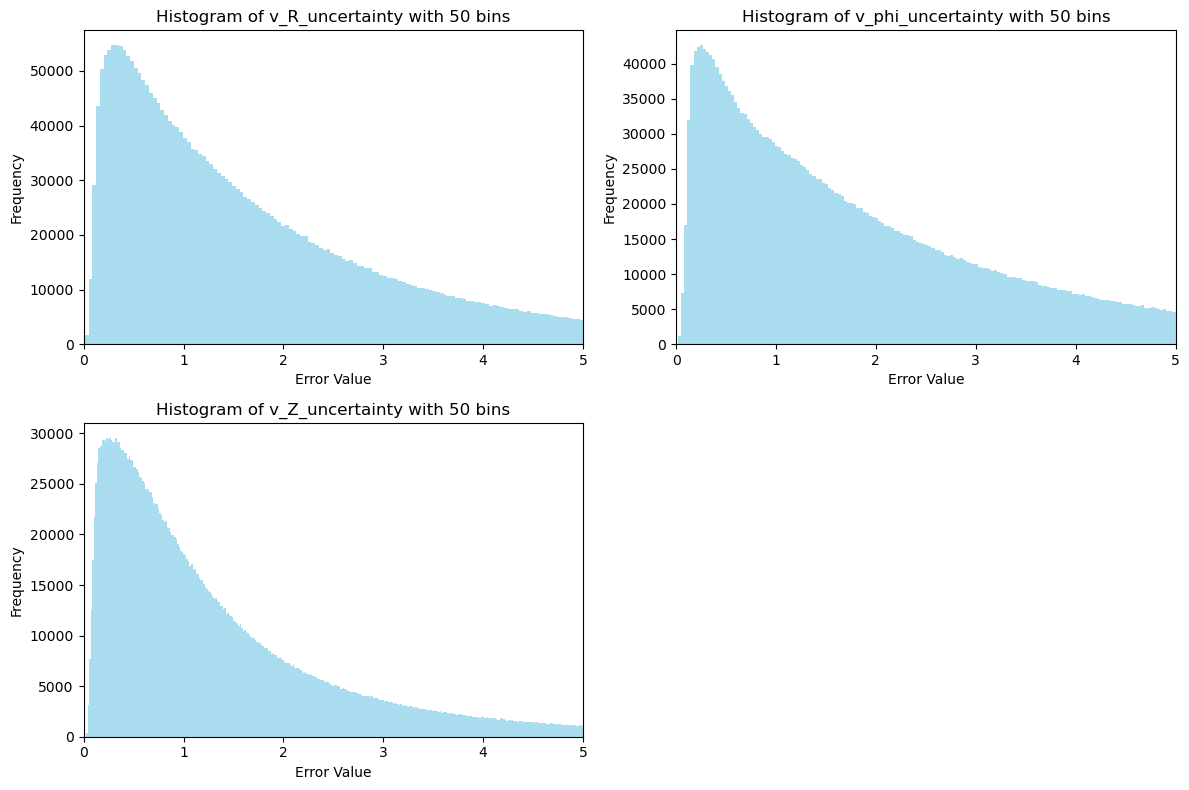

In [32]:
import matplotlib.pyplot as plt

# List of columns that are error-related (you can customize this based on your DataFrame's structure)
error_columns = ['v_R_uncertainty', 'v_phi_uncertainty', 'v_Z_uncertainty']  # Add any other error-related columns here

# Plot histograms for each error column with 50 bins, zoomed to 0-5
plt.figure(figsize=(12, 8))

for i, error_col in enumerate(error_columns):
    plt.subplot(2, 2, i + 1)  # Create a subplot for each error column
    plt.hist(df_v_final[error_col], bins=5000, color='skyblue', edgecolor=None, alpha=0.7)
    plt.title(f"Histogram of {error_col} with 50 bins")
    plt.xlabel('Error Value')
    plt.ylabel('Frequency')
    plt.xlim(0, 5)  # Zoom in on the range from 0 to 5 for better visualization

# Adjust layout for better visualization
plt.tight_layout()
plt.show()
